In [1]:
import numpy as np
import pandas as pd
import sklearn

import os
import re
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


# Load the data

In [2]:
# load the csv's obtained with 'arXiv_metadata_harvester.ipynb'

#dir_ = "arXivMeta_completed/"
dir_ = "arXivMeta_sample/"

dfs = {}

# create dict of file-lists dfs = {'cs': [file1, ...], 'math': ..., etc.}
for file in os.listdir(dir_):
    info = re.search(r'arXivMeta_(.+?)_(.+?)\.(\w+?)', file)
    cat = info.group(1)
    date = info.group(2)
    print(f'{cat:>9}: {date}')
    
    file_path = os.path.join(dir_, file)
    
    if cat not in dfs:
        dfs[cat] = [file_path]
    else:
        dfs[cat].append(file_path)

# create dict of data_frames dfs = {'cs': pd.DataFrame(), 'math': ..., etc.}       
def getdf(file_list):
    cat_dfs = [pd.read_csv(file, delimiter='\t') for file in file_list]
    return pd.concat(cat_dfs)

dfs = {cat: getdf(cat_files) for (cat, cat_files) in dfs.items()}

       cs: from_2016-01-01_to_2016-12-31
     math: from_2016-01-01_to_2016-07-01
     math: from_2016-07-02_to_2016-12-31
  physics: from_2016-01-01_to_2016-05-01
  physics: from_2016-05-02_to_2016-09-01
  physics: from_2016-09-02_to_2016-12-31
    q-bio: from_2016-01-01_to_2016-12-31
    q-fin: from_2016-01-01_to_2016-12-31
     stat: from_2016-01-01_to_2016-12-31


---

# Explore and select the data

In [92]:
# now we have for example

dfs['math'][:3]

,id,prim_cat,sec_cats,title,abstract
0,0704.0189,math,math.GR,Monoid generalizations of the Richard Thompson...,"The groups G_{k,1} of Richard Thompson and G..."
1,0704.1313,math,math.GT math.CO,Mutant knots and intersection graphs,We prove that if a finite order knot invaria...
2,0704.2146,math,math.CO,Connected Edge-Disjoint Unions of Tur\'an Graphs,A finite connected graph $G_r^\sigma$ is con...


In [3]:
# check if there are no duplicates (at least by 'id')

[(cat, 0 == len(df.id) - len(df.id.unique())) for (cat,df) in dfs.items()]

[('cs', True),
 ('math', True),
 ('physics', True),
 ('q-bio', True),
 ('q-fin', True),
 ('stat', True)]

In [5]:
# concat all data_frames into one

full_df = pd.concat(dfs.values())

# get a 10% sample to play with

sample_df = full_df.sample(frac=0.1, random_state=123)
sample_df.reset_index(inplace=True)
len(sample_df)

16128

In [6]:
def show_cats(df):
    
    cats = df.prim_cat.unique()
    record_counts = []
    
    for cat in cats:
        count = sum(df.prim_cat == cat)
        record_counts.append( [cat, count/1000] )
    
    record_counts = sorted(record_counts, key = lambda x: x[1], reverse=True)
    
    record_counts = np.array(record_counts)
    record_counts_df = pd.DataFrame({'categories': record_counts[:,0], '1000 papers': record_counts[:,1]}).set_index('categories')
    display(record_counts_df)
    record_counts_df.astype('float').plot.bar()
    plt.show()

,1000 papers
categories,
physics,8.003
math,4.546
cs,2.62
stat,0.565
q-bio,0.295
q-fin,0.099


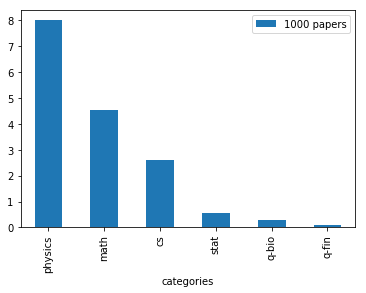

In [7]:
# plot the number of papers in each class
# the dataset is highly unbalanced, there's orders of magnitude between the most and the least frequent class

show_cats(sample_df)

# the world of quantative finance seems to be less keen on spending time writing papers than physicists

In [7]:
# get primary_categories (prim_cat) and text (title+abstract) only
# and safe those in 'bare data_frames'

def strip(df):
    df_2 = pd.concat([(df.title + " " + df.abstract).astype('str'),
                      df.prim_cat.astype('category')], axis=1)
    df_2.columns = ['text', 'label']
    return df_2

bare_dfs = {cat: strip(df) for (cat, df) in dfs.items()}

bare_sample_df = strip(sample_df)

In [8]:
# now we have for example

with pd.option_context('display.max_colwidth', 110):
    display(bare_sample_df[:3])

,text,label
0,The IBM 2016 Speaker Recognition System In this paper we describe the recent advancements made in the IB...,cs
1,The 2(2S+1)- Formalism and Its Connection with Other Descriptions In the framework of the Joos-Weinberg ...,math
2,Regression-based Intra-prediction for Image and Video Coding By utilizing previously known areas in an i...,cs


---

### One could also have a look at the papers' secondary categories of which there are almost 200 and there can be many such categories per paper. Maybe later...

In [93]:
# TODO side-project:
# classify by subcategories (first entries in the list in 'sec_cats' of each paper)

In [181]:
# one-hot-encode the 
ids_with_cats_ugly = full_df[['id', 'sec_cats']].set_index('id').sec_cats.str.split(expand=True).stack()
print(ids_with_cats_ugly[:10])

id_with_cats_df = pd.get_dummies(ids_with_cats_ugly).groupby(level=0).sum()
id_with_cats_df[:3]

id          
0704.0213  0      cs.CC
0704.0802  0      cs.IT
           1    math.IT
0704.1409  0      cs.LG
           1      cs.AI
0704.2452  0      cs.IT
           1    math.IT
0706.0534  0    stat.ML
           1      cs.IT
           2    math.IT
dtype: object


,acc-phys,adap-org,alg-geom,ao-sci,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,...,q-fin.TR,quant-ph,solv-int,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,supr-con
id,,,,,,,,,,,,,,,,,,,,,
0704.0005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0704.0006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0704.0020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [182]:
len(id_with_cats_df.columns)

173

In [184]:
# TODO take care of adap-org (nlin.AO), chao-dyn(nlin.CD), patt-sol (nlin.PS) etc.:

# Each category should be in the format 'general.specic' (e.g. 'astr-ph.CO') or just 'general' (e.g. 'astro-ph')
# but some of our columns are assigned to 'specific' in the spelled-out format (eg. chao-dyn instead of nlin.CD)
# See https://arxiv.org/ and http://arxitics.com/help/categories

# for column in id_with_cats_df:
#     print(column)

---

### Abstracts of scientific papers tend to be written in a formal style, not contain typos, no direct citations, little references, ...

In [97]:
# take a look at a few abstracts

import random
  
for _ in range(3):
    print(bare_sample_df.text.iloc[random.choice(range(len(bare_sample_df)))])
    print("---")

Cities and Regions in Britain through hierarchical percolation   Urban systems present hierarchical structures at many different scales. These
are observed as administrative regional delimitations which are the outcome of
complex geographical, political and historical processes which leave almost
indelible footprints on infrastructure such as the street network. In this work
we uncover a set of hierarchies in Britain at different scales using
percolation theory on the street network and on its intersections which are the
primary points of interaction and urban agglomeration. At the larger scales,
the observed hierarchical structures can be interpreted as regional fractures
of Britain, observed in various forms, from natural boundaries, such as
National Parks, to regional divisions based on social class and wealth such as
the well-known North-South divide. At smaller scales, cities are generated
through recursive percolations on each of the emerging regional clusters. We
examine the evo

### One messy but informative kind of writing they have are LateX formulas.

In [98]:
bare_sample_df.text[8]

'Functional determinants, index theorems, and exact quantum black hole\r\n  entropy   The exact quantum entropy of BPS black holes can be evaluated using\r\nlocalization in supergravity. An important ingredient in this program, that has\r\nbeen lacking so far, is the one-loop effect arising from the quadratic\r\nfluctuations of the exact deformation (the $Q\\mathcal{V}$ operator). We compute\r\nthe fluctuation determinant for vector multiplets and hyper multiplets around\r\n$Q$-invariant off-shell configurations in four-dimensional $\\mathcal{N}=2$\r\nsupergravity with $AdS_{2} \\times S^{2}$ boundary conditions, using the\r\nAtiyah-Bott fixed-point index theorem and a subsequent zeta function\r\nregularization. Our results extend the large-charge on-shell entropy\r\ncomputations in the literature to a regime of finite charges. Based on our\r\nresults, we present an exact formula for the quantum entropy of BPS black holes\r\nin $\\mathcal{N}=2$ supergravity. We explain cancellations co

### Let's map those into a single 'word'

In [94]:
# mask all LaTeX with a single word ' _LATEX_ '

from sklearn.base import BaseEstimator, TransformerMixin

class DeLaTeX(BaseEstimator, TransformerMixin):
    """
    Replace '\$(.+)?\$' with ' _LATEX_ '
    """

    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace(r'\$(.+)?\$', ' _LATEX_ ')

In [95]:
delatex = DeLaTeX()
delatex.transform(bare_sample_df.text)[8]

'Functional determinants, index theorems, and exact quantum black hole\r\n  entropy   The exact quantum entropy of BPS black holes can be evaluated using\r\nlocalization in supergravity. An important ingredient in this program, that has\r\nbeen lacking so far, is the one-loop effect arising from the quadratic\r\nfluctuations of the exact deformation (the  _LATEX_  operator). We compute\r\nthe fluctuation determinant for vector multiplets and hyper multiplets around\r\n _LATEX_ \r\nsupergravity with  _LATEX_  boundary conditions, using the\r\nAtiyah-Bott fixed-point index theorem and a subsequent zeta function\r\nregularization. Our results extend the large-charge on-shell entropy\r\ncomputations in the literature to a regime of finite charges. Based on our\r\nresults, we present an exact formula for the quantum entropy of BPS black holes\r\nin  _LATEX_  supergravity. We explain cancellations concerning\r\n _LATEX_  supergravity that were observed in\r\narXiv:1111.1161. We also make com

---

## Let's build a simple untuned pipeline with a couple shallow classifiers
### We relay on the *class_weight* argument to account for the imbalance of our data

In [99]:
# Choose the data_frame

work_df = bare_sample_df

print(len(work_df))
work_df.dtypes

16128


text       object
label    category
dtype: object

In [100]:
from sklearn.model_selection import train_test_split

text_train, text_test, label_train, label_test = train_test_split(work_df.text, work_df.label, test_size=0.33, random_state=123)

In [102]:
# encode the labels, 'cs' -> 0, ..., 'stat' -> 5

from sklearn import preprocessing

label_e = preprocessing.LabelEncoder()
y_train = label_e.fit_transform(label_train)
y_test = label_e.transform(label_test)

print(list(label_e.classes_))

#label_e.inverse_transform([0]) # array(['cs'], dtype=object)

['cs', 'math', 'physics', 'q-bio', 'q-fin', 'stat']


### Let's first build the pipe and push the data trough step by step.

In [25]:
notex_text_train = delatex.fit_transform(text_train)
notex_text_test = delatex.transform(text_test)

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

count_v = CountVectorizer(strip_accents='unicode', min_df = 2, max_df = 0.8)
word_counts_train = count_v.fit_transform(notex_text_train)
word_counts_test = count_v.transform(notex_text_test)
word_counts_train.shape

(10805, 19250)

In [29]:
# Why is there fewer rows? Were they empty?

In [30]:
# take a look at the most frequent words (after using the 'max_df' above)

sum_word_counts_train = word_counts_train.sum(axis=0)
sorted([(sum_word_counts_train[0, i], word) for word, i in count_v.vocabulary_.items()],reverse=True)[:35]

# There's a lot of '_latex_'.
# Yet I would still hope that it is underrepresented in quantitative biology or quantitative finance
#
# Maybe we should have balanced the classes...

[(21230, 'is'),
 (20436, 'for'),
 (15495, 'that'),
 (14938, '_latex_'),
 (14689, 'with'),
 (12535, 'on'),
 (11021, 'this'),
 (10733, 'are'),
 (10459, 'by'),
 (8571, 'as'),
 (8240, 'an'),
 (6780, 'be'),
 (6578, 'from'),
 (6384, 'which'),
 (5596, 'at'),
 (5067, 'can'),
 (4967, 'model'),
 (4231, 'two'),
 (4055, 'our'),
 (4035, 'it'),
 (3663, 'these'),
 (3630, 'results'),
 (3625, 'using'),
 (3616, 'show'),
 (3377, 'time'),
 (3367, 'data'),
 (3305, 'also'),
 (3185, 'based'),
 (3029, 'between'),
 (3006, 'or'),
 (2914, 'field'),
 (2886, 'paper'),
 (2851, 'quantum'),
 (2778, 'one'),
 (2763, 'have')]

In [103]:
from sklearn.pipeline import Pipeline

def build_arXivMeta_clf(model):
    pipe = []
    pipe.append(( 'delatex', DeLaTeX() ))
    pipe.append(( 'count_v', CountVectorizer(strip_accents='unicode', min_df = 2, max_df = 0.8)  ))
    pipe.append(( 'tfidf_t', TfidfTransformer(use_idf=False)  ))
    pipe.append(( 'sgd_clf', model  ))

    return Pipeline(pipe)

In [104]:
# our first model, an linear SVMM with stochastic gradient descent

arXivMeta_clf_1 = build_arXivMeta_clf(
    SGDClassifier(loss='hinge', class_weight="balanced", n_jobs=-1, max_iter=1000, tol=1e-3)
)
arXivMeta_clf_1.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX()), ('count_v', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, sto..._state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

### Ok, let's just have some fun first:

In [106]:
random_abstracts = pd.Series(["""
The Lack of A Priori Distinctions Between Learning Algorithms  This is the first of
two papers that use off-training set (OTS) error to investigate the assumption-free
relationship between learning algorithms. This first paper discusses the senses in
which there are no a priori distinctions between learning algorithms. (The second
paper discusses the senses in which there are such distinctions.) In this first paper
it is shown, loosely speaking, that for any two algorithms A and B, there are "as many"
targets (or priors over targets) for which A has lower expected OTS error than B as
vice versa, for loss functions like zero-one loss. In particular, this is true if A
is cross-validation and B is "anti-cross-validation'' (choose the learning algorithm
with largest cross-validation error). This paper ends with a discussion of the
implications of these results for computational learning theory. It is shown that one
cannot say: if empirical misclassification rate is low, the Vapnik-Chervonenkis
dimension of your generalizer is small, and the training set is large, then with high
probability your OTS error is small. Other implications for "membership queries"
algorithms and "punting" algorithms are also discussed.
""",
"""
X-rays quarks lepton scattering experiment field
""",
"""
genes DNA RNA sequencing protein species fenotype 
""",
"""
computer algorithm graph sorting depth first interface
""",
"""
We offer a novel less intuitive proof of $\limit_{x\to 0} x = 0$,
""",
"""
infllation resources market stock bonds derivatives
""",
"""
distribution Bayesian p value marginalization Monte Carlo
"""
])


label_e.inverse_transform(arXivMeta_clf_1.predict(random_abstracts))

array(['cs', 'physics', 'q-bio', 'cs', 'math', 'q-fin', 'stat'], dtype=object)

In [69]:
# look promising

### Check the multilabel classification accuracy

In [107]:
from sklearn import metrics

def show_metrics(clf):
    predicted_y_test = clf.predict(text_test)
    print(metrics.classification_report(y_test, predicted_y_test, target_names=label_e.classes_))
    print(metrics.confusion_matrix(y_test, predicted_y_test))

In [108]:
show_metrics(arXivMeta_clf_1)

              precision    recall  f1-score   support

          cs       0.68      0.73      0.70       894
        math       0.80      0.73      0.76      1510
     physics       0.93      0.90      0.92      2633
       q-bio       0.44      0.59      0.51        80
       q-fin       0.58      0.50      0.54        30
        stat       0.34      0.59      0.43       176

   micro avg       0.81      0.81      0.81      5323
   macro avg       0.63      0.67      0.64      5323
weighted avg       0.82      0.81      0.81      5323

[[ 652  104   31   11    3   93]
 [ 195 1106  122   10    8   69]
 [  71  140 2364   28    0   30]
 [  12    3   10   47    0    8]
 [   2    7    1    0   15    5]
 [  31   28    3   10    0  104]]


In [109]:
# TODO: understand what the above values are

In [110]:
# try a random forest

from sklearn.ensemble import RandomForestClassifier

arXivMeta_clf_2 = build_arXivMeta_clf(
    RandomForestClassifier(class_weight = 'balanced', n_estimators=100, max_depth=10, criterion='entropy', random_state=123)
)
arXivMeta_clf_2.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX()), ('count_v', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, sto...tors=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False))])

In [111]:
show_metrics(arXivMeta_clf_2)

              precision    recall  f1-score   support

          cs       0.61      0.59      0.60       894
        math       0.67      0.74      0.70      1510
     physics       0.89      0.81      0.85      2633
       q-bio       0.31      0.41      0.35        80
       q-fin       0.62      0.43      0.51        30
        stat       0.33      0.48      0.40       176

   micro avg       0.74      0.74      0.74      5323
   macro avg       0.57      0.58      0.57      5323
weighted avg       0.75      0.74      0.74      5323

[[ 530  198   64   15    3   84]
 [ 176 1119  156    7    5   47]
 [  96  318 2145   45    0   29]
 [  15    3   22   33    0    7]
 [   4    9    2    0   13    2]
 [  46   30    8    7    0   85]]


In [ ]:
# TODO:

# make the confusion matrix with a heat_map  

# grid search with cross validation
# try Hash Vectorizer instead of CountVectorizer
# balance the classes by up-/down-sampling and use LogisticRegression, NaiveBayes, ...
# out-of-core learning ?

# see how accuracy scales with data volume (we have 800 MB to go around)

# unsupervised learning:
# LDA
# clustering
# visualization: t-SNE ?

# deep learning ?